## Generating Pyramids with ndpyramid resample

This demo is a walkthrough of how to generate multiscale pyramids with `ndpyramid's` `reproject` method via `pangeo-forge-recipes`.
Details on creating pangeo-forge-pipelines can be found [here](https://pangeo-forge.readthedocs.io/en/latest/).



### Input dataset 

We are using a zarr store of downscaled CMIP6 data. Details on the input dataset can be found [here](https://github.com/carbonplan/cmip6-downscaling).



## Import Libraries

In [1]:
import apache_beam as beam
import xarray as xr
import fsspec 
import datatree as dt 

from pangeo_forge_ndpyramid.transforms import StoreToPyramid
from pangeo_forge_recipes.transforms import OpenWithXarray, ConsolidateMetadata
from pangeo_forge_recipes.patterns import FileType, pattern_from_file_sequence
from pangeo_forge_recipes.storage import FSSpecTarget


In [2]:
# Create an input file pattern. For more info see: https://pangeo-forge.readthedocs.io/en/latest/composition/file_patterns.html
pattern = pattern_from_file_sequence(['https://rice1.osn.mghpcc.org/carbonplan/cp-cmip/version1/rechunked_data/GARD-SV/ScenarioMIP.CCCma.CanESM5.ssp245.r1i1p1f1.month.GARD-SV.tasmax.zarr'], concat_dim="time")





### Create a custom Pangeo-Forge transform to subset our dataset

In [3]:
from dataclasses import dataclass
@dataclass
class Subset(beam.PTransform):
    """Custom PTransform to select two days and single variable"""
    def _subset(self, ds: xr.Dataset) -> xr.Dataset:
        ds = ds.isel(time=slice(0,2))[['tasmax']]
        return ds

    def expand(self, pcoll):
        return pcoll | 'subset' >> beam.MapTuple(lambda k, v: (k, self._subset(v)))


### Specify where to write the pyramids

In [4]:
# Creating a local directory to write pyramids to. You can also write to cloud storage.
fs = fsspec.get_filesystem_class("file")()
target_root = FSSpecTarget(fs, 'pyramid_outputs/reproject/')


### Additional arguments for reproject method
`ndpyramid's` reproject method depends on Rioxarray which requires the spatial dimensions to be named 'lat' and 'lon'. You can rename these dimensions by passing in the kwarg `rename_spatial_dims`.



## Creating pyramids via the reproject method
Here we are adding the transform `StoreToPyramid` to create pyramids in a pangeo-forge pipeline.

In [5]:


with beam.Pipeline() as p:
    (
        p
        | beam.Create(pattern.items())    
        | OpenWithXarray(file_type=FileType("zarr"), xarray_open_kwargs={"chunks": {}})
        | Subset()
        | StoreToPyramid(
        target_root=target_root,
        store_name='pyramid_example_reproject.zarr',
        epsg_code="4326",
        pyramid_method="reproject",
        levels=2,
        combine_dims=pattern.combine_dim_keys,
    )
    | ConsolidateMetadata()
    )
    

## Open pyramid as datatree
We can now open the resulting multiscale zarr pyramid with `xarray-datatree`

In [6]:
dst = dt.open_datatree(target_root.root_path + '/pyramid_example_reproject.zarr',engine='zarr')

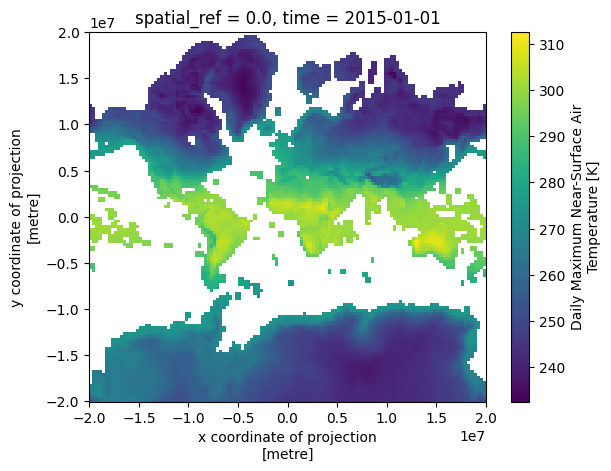

In [7]:
dst['1'].to_dataset().isel(time=0).tasmax.plot()